# 仕訳データの有効グラフ表現

簿記でいう勘定連絡図のようなものを有効グラフで表現してみます。勘定連絡図についてはググってください。

### 0. セットアップ

1. matplotlibに日本語のフォントを追加、設定します。

2. 今回は有限会社アイソフトの製品「税理士いらず」のサンプルデータ「株式会社サンプルデザイン」をお借りします。以下のサイトから仕訳データをダウンロードし、好きな場所に置きます（以下ではこのスクリプトファイルと同じディレクトリに"testdata.csv"の名称で置いてあることを想定してます）。

http://www.z-irazu.jp/sample.html

### 1. データの読み込み

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
filename='./testdata.csv'
JE_raw=pd.read_csv(filename, \
                   header=None,index_col=False, engine="python", encoding="SHIFT-JIS",\
                   names=['date','debit_account_name','debit_amount','debit_tax','credit_account_name','credit_amount','credit_tax','description_1','description_2'])

In [3]:
JE_raw.head(10)

,date,debit_account_name,debit_amount,debit_tax,credit_account_name,credit_amount,credit_tax,description_1,description_2
0,2018/ 4/ 4,現金,1000000,NaN,普通預金,1000000,NaN,引出し,NaN
1,2018/ 4/ 5,水道光熱費,17653,課税(8%),普通預金,17653,NaN,電気料金振替,NaN
2,2018/ 4/ 6,消耗品費,6480,課税(8%),現金,6480,NaN,名刺代,NaN
3,2018/ 4/ 9,普通預金,500000,NaN,現金,500000,NaN,預入れ,NaN
4,2018/ 4/10,水道光熱費,4329,課税(8%),普通預金,4329,NaN,ガス料金振替,NaN
5,2018/ 4/10,消耗品費,4320,課税(8%),現金,4320,NaN,コピー用紙,NaN
6,2018/ 4/10,未払費用,191600,NaN,普通預金,191600,NaN,鈴木淑子,給料（３０年３月手取り支給分の支払）
7,2018/ 4/10,未払費用,98730,NaN,普通預金,98730,NaN,田中信夫,役員給与（３０年３月手取り支給分の支払）
8,2018/ 4/10,未払費用,476490,NaN,普通預金,476490,NaN,鈴木一郎,役員給与（３０年３月手取り支給分の支払）
9,2018/ 4/11,通信費,3700,課税(8%),現金,3700,NaN,郵便料金,NaN


### 2. 行列データの作成

In [4]:
Names=np.concatenate([JE_raw.loc[:,'debit_account_name'].values,JE_raw.loc[:,'credit_account_name'].values])
TBindex=np.unique(Names)

In [5]:
transaction_mat=pd.DataFrame(np.zeros((TBindex.shape[0],TBindex.shape[0])),dtype=int)
transaction_mat.index=TBindex
transaction_mat.columns=TBindex

In [6]:
for itr in range(JE_raw.shape[0]):
    rcd=JE_raw.iloc[itr,:]
    mask_d=rcd["debit_account_name"] == TBindex
    mask_c=rcd["credit_account_name"] == TBindex
    transaction_mat.iloc[mask_d,mask_c]=transaction_mat.iloc[mask_d,mask_c]+rcd['debit_amount']

In [7]:
transaction_mat_net=pd.DataFrame(np.zeros((TBindex.shape[0],TBindex.shape[0])),dtype=int)
transaction_mat_net.index=TBindex
transaction_mat_net.columns=TBindex
transaction_mat_net.loc[:,:]=(transaction_mat.values+transaction_mat.values.transpose())/2

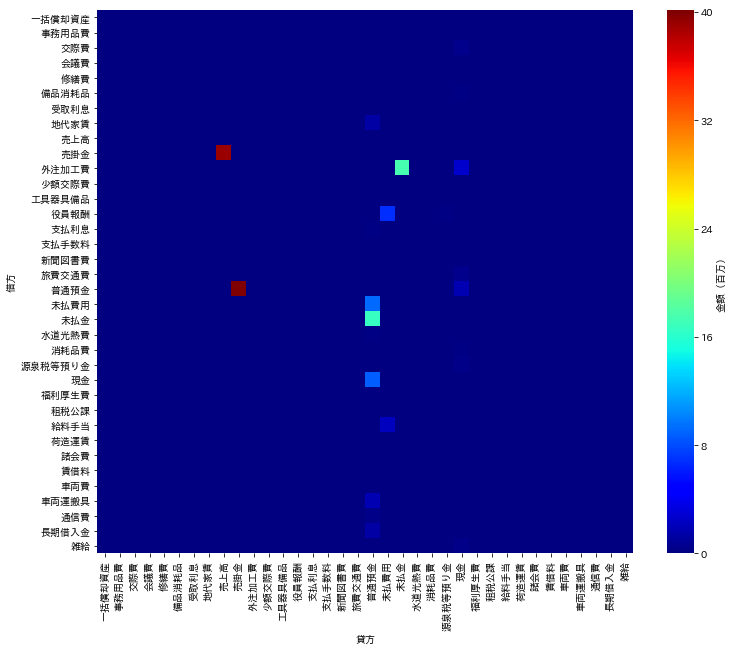

In [8]:
plt.figure(figsize=(12,10))
ax=sns.heatmap(transaction_mat/1000000,cmap='jet',cbar_kws={'label': '金額（百万）'})
tmp = ax.set(xlabel='貸方', ylabel='借方') 

行は借方、列は貸方です。ヒートマップの色は金額を表します。
この行列データは3.以下で登場するグラフ表現と等価です。
行列の[売掛金,売上高]のセルが赤くなってますが、これは、以下の仕訳の累積金額(XXX)が大きいことを意味します。

借方：売掛金 XXX / 貸方:売上高 XXX

### 3. 仕訳の金額重み付き共起関係を無向グラフで表現

In [9]:
df=transaction_mat_net
threshold=0.000001
G=nx.Graph()
edge_labels={}
for a, b in itertools.combinations(df.columns, 2):
        val1 = df.loc[a, b]
        if abs(val1) > threshold:
            edge_labels[(a,b)]=np.round(val1/1000000,1).astype(str) + " M"
            weigth_tmp=10 * (abs(np.log10(val1)/7) - threshold) / (1 - threshold)
            G.add_edge(a,b, weight=weigth_tmp)        

In [17]:
pos = nx.spring_layout(G) # グラフのポジションを力学モデルで決定します。

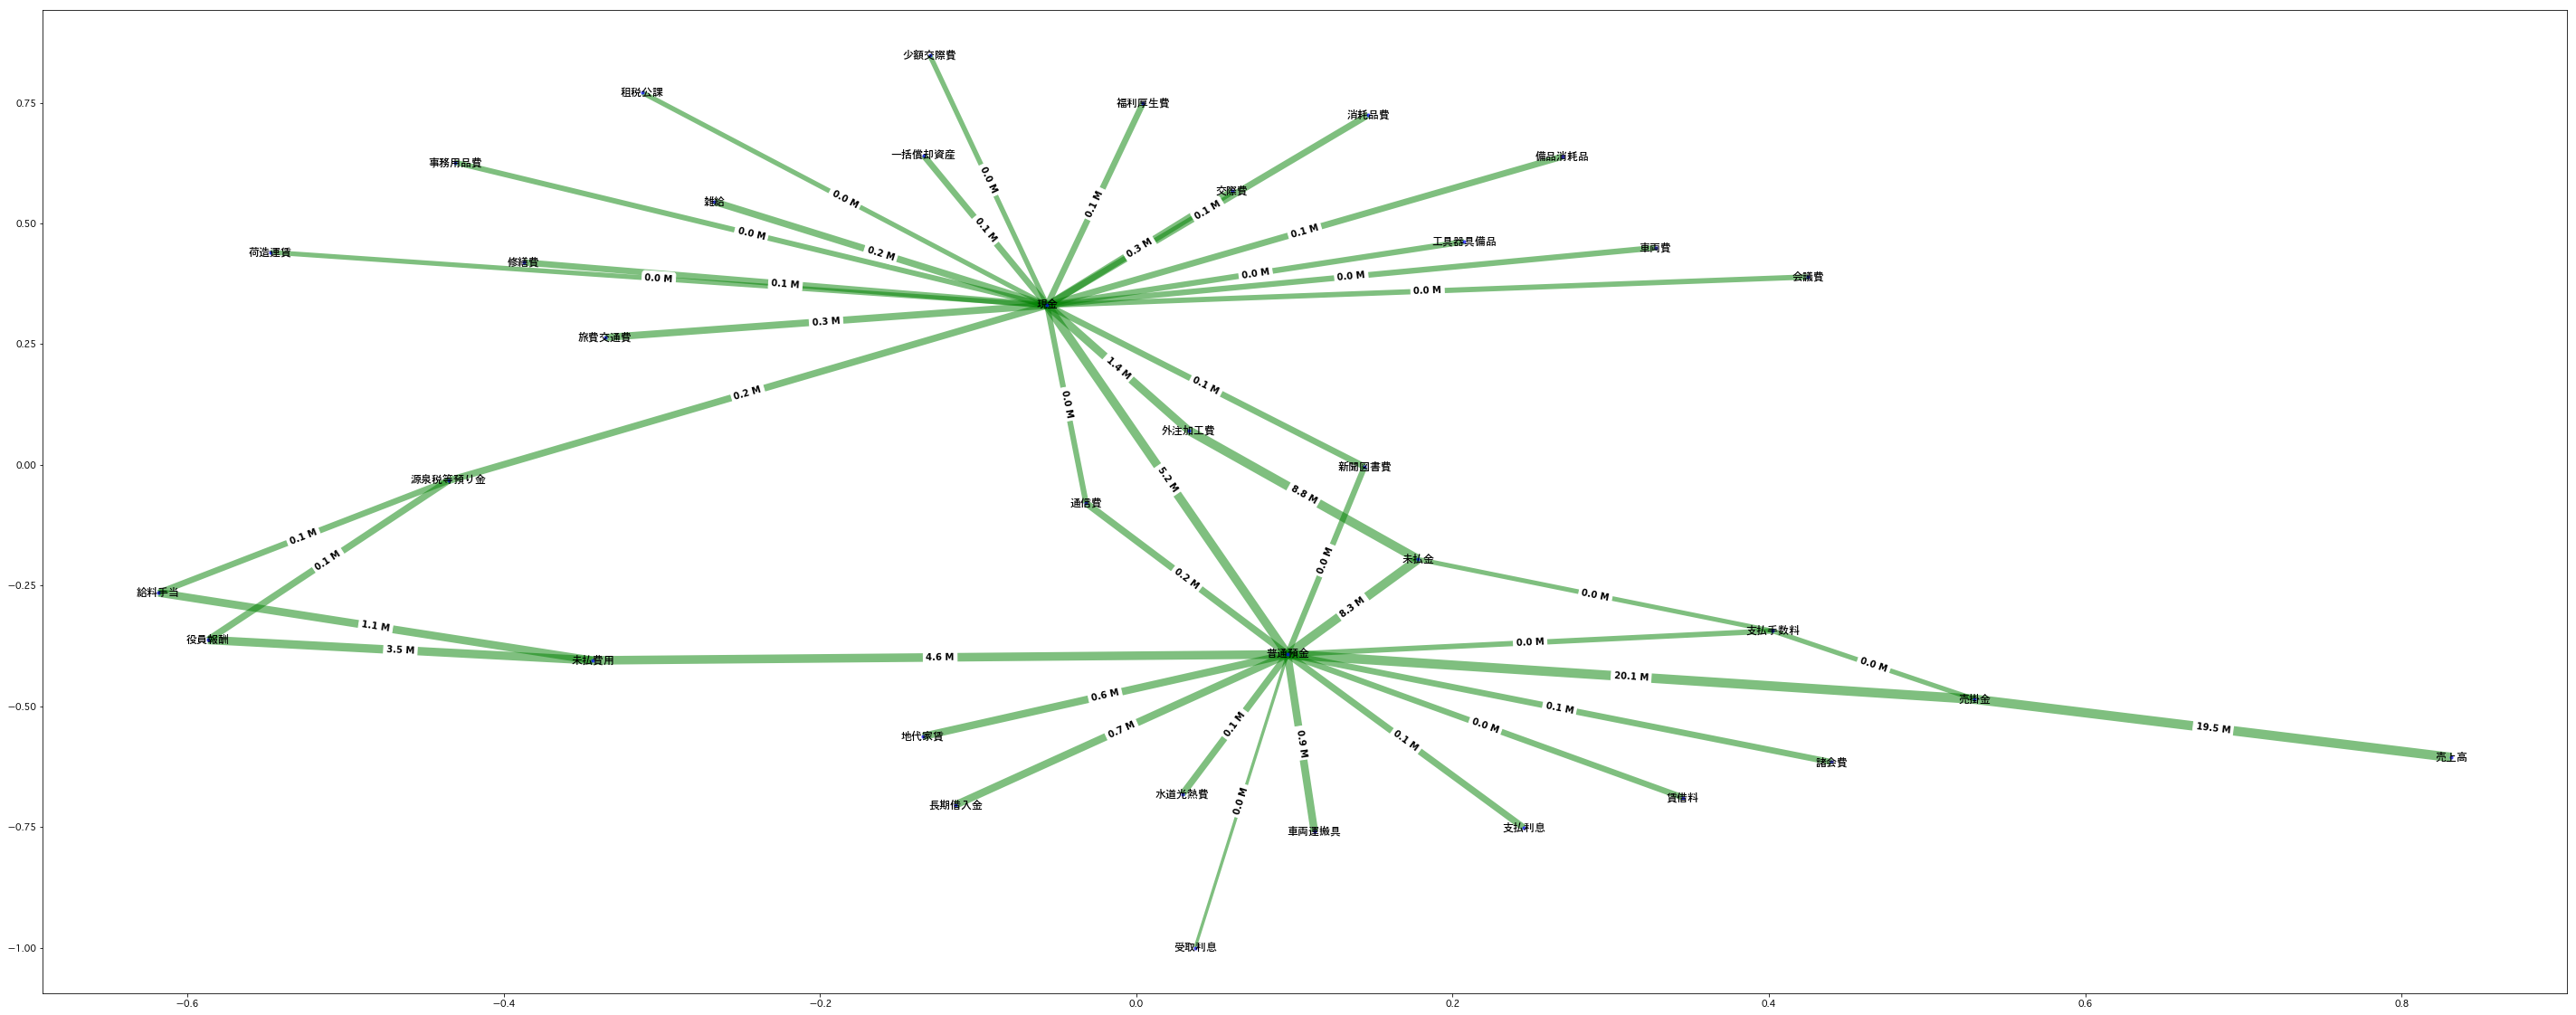

In [18]:

plt.rcParams['font.family'] = 'Osaka'
plt.figure(figsize=(50,20))

node_size = 10 
nx.draw_networkx_nodes(G, pos, node_color="b",alpha=0.6, node_size=node_size)
nx.draw_networkx_labels(G, pos, fontsize=32, font_family='Osaka', font_weight="bold")
edge_width = [ d["weight"] for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="g", width=edge_width)
nx.draw_networkx_edge_labels(G, pos,fontsize=32,edge_labels=edge_labels,font_weight="bold")
plt.figure(figsize=(50,20))

例えば、売掛金と売上高のノード間に19.5 Mのエッジがありますが、これは以下の仕訳の合計金額が19.5 Mであることを意味します（Mは百万です）。

売掛金 xx / 売上高 xx

これでも良いですが、借方と貸方がグラフ表現では区別できません。そこで、次に有効グラフで借方と貸方を反映させます。

なお、グラフの形は力学モデルでもっともエネルギーを最小化して決めているため、アルゴリズムの性質上実行ごとに形が変わります。

### 4. 有向グラフ表現（矢印は借方→貸方を意味します） 

In [19]:
df=transaction_mat
threshold=0.000001
G=nx.MultiDiGraph()
edge_labels={}
for a, b in itertools.combinations(df.columns, 2):
        val1 = df.loc[a, b]
        if abs(val1) > threshold:
            edge_labels[(a,b)]=np.round(val1/1000000,1).astype(str) + " M"
            weigth_tmp=10 * (abs(np.log10(val1)/7) - threshold) / (1 - threshold)
            G.add_edge(a,b, weight=weigth_tmp)
        
        val2 = df.loc[b, a]
        if abs(val2) > threshold:
            edge_labels[(b,a)]=np.round(val2/1000000,1).astype(str) + " M"
            weigth_tmp=10 * (abs(np.log10(val2)/7) - threshold) / (1 - threshold)
            G.add_edge(b,a, weight=weigth_tmp)

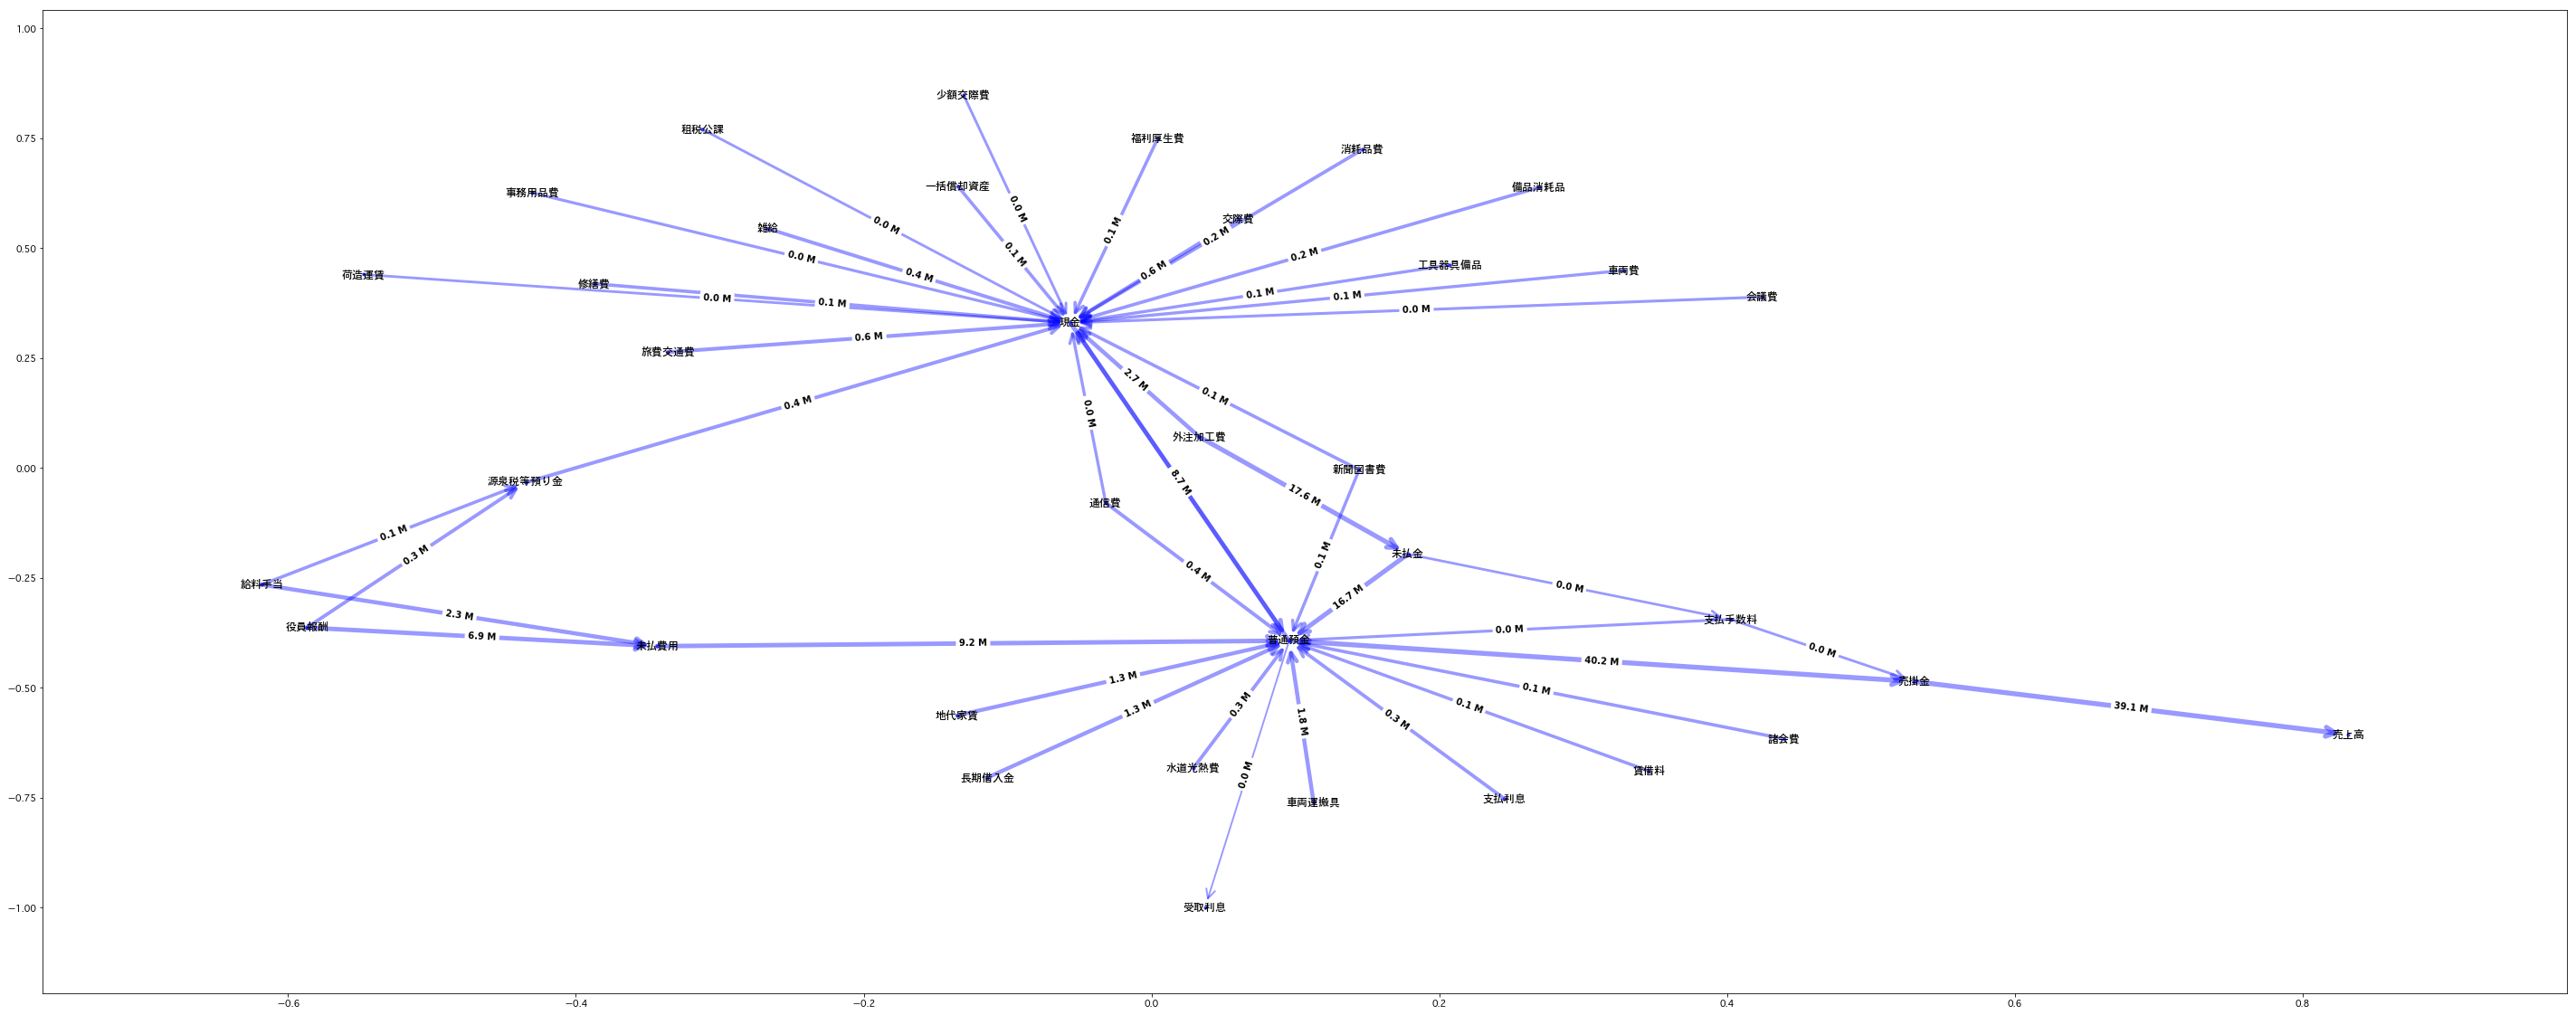

In [20]:

plt.rcParams['font.family'] = 'Osaka'
plt.figure(figsize=(50,20))

node_size = 10
nx.draw_networkx_nodes(G, pos, node_color="b",alpha=0.6, node_size=node_size)
nx.draw_networkx_labels(G, pos, fontsize=20, font_family='Osaka', font_weight="bold")
edge_width = [ d["weight"]*0.5 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="b", width=edge_width, arrows=True, arrowsize=25,arrowstyle='->',connectionstyle="arc3,rad=-0.3")
nx.draw_networkx_edge_labels(G, pos,fontsize=32,edge_labels=edge_labels,font_weight="bold")
plt.figure(figsize=(50,20))

### 5. 結果の解釈

勘定連絡図をよく表現しています。例えば、以下のようなことが観察されます。
* 現金や預金で支払時に経費を計上するような取引はシンプルですが、債権債務が間に入るとグラフは複雑になります。ファクタリング等があるとさらに複雑になりそうです。
* グラフのエッジが1種類の仕訳に対応するので、特定の勘定について周辺のエッジを見ることで取引がイメージできます。
* つまり、特定の勘定に繋がるエッジに会計的な意味があります。これは6.2で述べるGraph Convolutionの適用余地があることを示します。



### 6. 議論

#### 6.1 勘定残高の増減ベクトル表現 vs グラフ表現

仕訳を勘定残高の増減ベクトルで表現する場合では、例えば、1日単位で仕訳を集計してしまうと、ある勘定の増減にどの相手勘定の増減が対応するのかの情報が失われてしまいます。
一方で、グラフ表現では、仕訳ごとに集計されるため、そのようなことはありません。この点で、勘定残高の増減ベクトル表現に対して仕訳の情報を保てています。

#### 6.2 グラフ表現を活かした特徴抽出

グラフデータからの特徴抽出方法の一つにGraph Convolution Neural network (GNN:[1])があります。これはConvolutional Neural Networkをグラフデータに適用できるように拡張した手法です。

グラフ構造に意味のあるデータは、化合物（タンパク質）、メール(SNS)、Blockchain、路線図など多く存在し、GNNが応用されてます。
会計仕訳データのグラフ表現も仕入、材料、棚卸資産のように意味のある一連の勘定増減を隣接ノード間のエッジで表現するため、GNNの適用余地があります([2])。

例えば、グラフ構造の異常検知を用いて非定型的な仕訳の抽出ができることが期待されます。よりたくさんのデータを入手できれば、有用な特徴を仕訳データから抽出できるかもしれません。

#### 6.3 限界

グラフ表現に変換するには、勘定の増減が1対1で対応している必要があります。
例えば、以下の仕訳

売掛金 60 / 売上 100

前受金 40

は次の仕訳に変換でき、売掛金→売上と前受金→売上の2つのエッジで表現できます。

売掛金 60 / 売上 60

前受金 40 / 売上 40

しかし、移転された事業に対してのれんを認識する場合には、のれんがどの移転資産に対応するか不明なため、上記のような変換ができません。

また、会社によっては一時的な勘定科目（プログラムでいうtmp的な）を使ってる場合もあり、このデータにそのまま適用しても上手くいきません。

これらをグラフデータに変換するには、計算結果にバイアスが乗らない何らかのアルゴリズムが必要になります。


### 7. References

[1] Kipf & Welling et al., Semi-Supervised Classification with Graph Convolutional Networks

[2] Dhivya et al., Detecting Anomalies in Streaming Graphs. https://doi.org/10.1145/3219819.3220040